In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [143]:
class AnalyseDefectsAll:
    def __init__(self, system_size_list, ):
        self.LX = system_size_list
        self.inputs_paths = [f"data\\nematic_analysis{LX}_LL0.05\\merged_results" for LX in self.LX]
        self.act_list = [list(np.loadtxt(os.path.join(path, "activity_list.txt"))) for path in self.inputs_paths]
        self.Nactivity = [len(act) for act in self.act_list]

    def plot_av_defects(self, fit_dict = {}, act_bounds = None, plot_density = True, verbose = False,):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'param_guess': guess for the fit parameters
        """
 
        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            param_guess = fit_dict['param_guess']

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            norm = LX**2 if plot_density else 1

            try:
                av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
            except:
                print('Average defects not found. Analyse defects first.')
                return
   
            ax.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i], label = f'L = {self.LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
        
            if do_fit:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = self.act_list[i].index(act_bounds[0])
                    act_idx_bounds[1] = self.act_list[i].index(act_bounds[1]) + 1
     
                activities = np.array(self.act_list[i][act_idx_bounds[0]:act_idx_bounds[1]])
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                    fit = do_chi2_fit(fit_func, activities, av_defects[act_idx_bounds[0]:act_idx_bounds[1], 0], \
                                av_defects[act_idx_bounds[0]:act_idx_bounds[1], 1], parameter_guesses = param_guess, verbose=verbose)
                    Ndof, chi2, pval = get_statistics_from_fit(fit, len(activities), subtract_1dof_for_binning = False)

                  
                    print(f'For LX = {LX}:')
                    print("Valid minimum: ", fit.fmin.is_valid)
                    print('Params: ', fit.values[:])
                    print(f'Ndof = {Ndof}, chi2 = {chi2:.3f}, pval = {pval:.3f}\n')
                    
                #  d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                #  text = nice_string_output(d, extra_spacing=4, decimals=3)
                #  add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

                ax.plot(activities, fit_func(activities, *fit.values[:]), '-', color = f'C{i}', label=rf'Fit $L = {LX}$', linewidth = 2)
        
        if do_fit:
            ax.text(0.10, 0.95, rf'Fit = {fit_string}', transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')

        ax.legend(loc='lower right')
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')    
        fig.tight_layout()
        return fig, ax

    def plot_alpha_mean(self, use_density_fit = False, act_bounds = None):
        
        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
        for i, LX in enumerate(self.LX):
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
            
            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[i], label = f'L = {self.LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax


In [ ]:

# plot weighted mean and error on mean for all frames and activities
fig2, ax2 = plt.subplots(figsize=(9,6))

for i, act in enumerate(act_list):
        ax2.errorbar(act, hu_fit_params[i][:,0], hu_fit_params[i][:,2], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)

ax2.set_xlabel(r'$\zeta$')
ax2.set_ylabel(r'$\langle \alpha \rangle$')

ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [144]:
system_size_list = [256, 512, 1024]
ada = AnalyseDefectsAll(system_size_list)

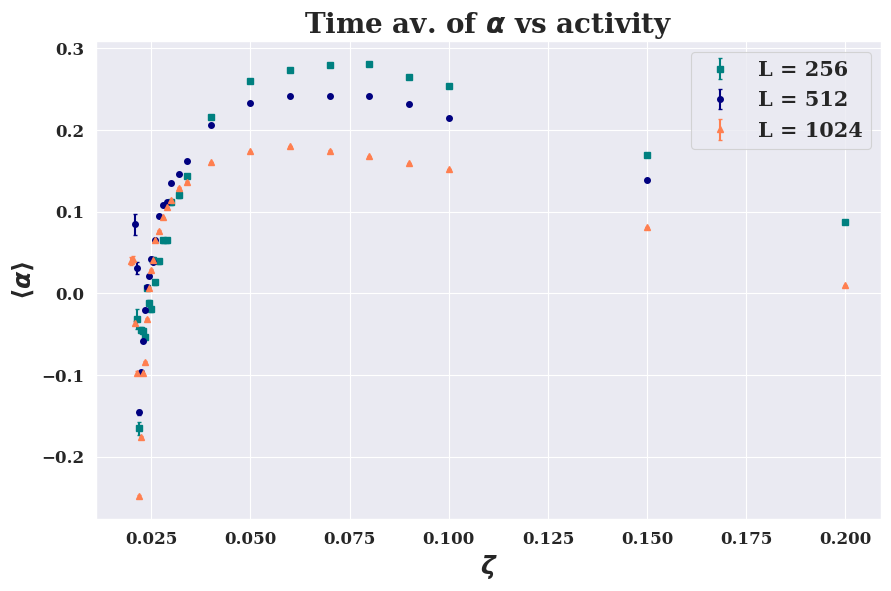

In [148]:
ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.25]);

In [105]:
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
def linear(x, a, b):
    return a * x + b
def log(x, a, b):
    return a * np.log(x) + b
def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density

fit_func = logistic_func


fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_log = rf'$y = a \ln x + bx + c $'
fit_string_lin = rf'$y = a x + b$'
param_guess_log = np.array([0.005, 0.04,0.015])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.04,0.015])
param_guess_logistic = np.array([0.002, 2000, 0.023,])
fit_dict = dict(fit_func = logistic_func, fit_string = fit_string_lin, lower_act_index = 12, param_guess = param_guess_logistic)


In [ ]:
fig, ax = ada.plot_av_defects(fit_dict=fit_dict,act_bounds=[0.02, 0.025])
ax.set_xlim([0.018,0.032])
ax.set_ylim([0, 0.005])
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend(loc='upper right')

In [4]:
input_paths = [os.path.join('data', dir) for dir in os.listdir(data_paths)]
input_paths.remove(os.path.join('data', 'nematic_analysis256_old'))
input_paths.remove(os.path.join('data', 'nematic_analysis_all'))
save_path = 'data\\nematic_analysis_all'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Nexp = 10
Nframes = 181

LX = []
for inp in input_paths:
    LX.append(int(inp.split('analysis')[-1].split('_')[0]))
# sort input paths by system size
input_paths = [input_paths[i] for i in np.argsort(LX)]
LX = np.sort(LX)




In [106]:
act_list = [list(np.loadtxt(os.path.join(input_paths[i], 'act_list.txt'))) for i in range(len(input_paths))]
av_defects = [np.load(os.path.join(input_paths[i], 'av_defects.npy')) for i in range(len(input_paths))]
hu_fit_params = [np.load(os.path.join(input_paths[i], f'fit_params_lin_normalizeTrue_time_av.npy')) for i in range(len(input_paths))]
hu_stats = [np.load(os.path.join(input_paths[i], f'stat_arr_lin_normalizeTrue_time_av.npy')) for i in range(len(input_paths))]

xi_av = [np.load(os.path.join(input_paths[i], f'xi_av_full.npy')) for i in range(len(input_paths))]
xi_std = [np.load(os.path.join(input_paths[i], f'xi_std_full.npy')) for i in range(len(input_paths))]

binder_tot = [np.load(os.path.join(input_paths[i], f'binder_tot.npy')) for i in range(len(input_paths))]

act_remove_list = [0.25, 0.30]
# remove all activities above act_remove_list
for i in range(len(input_paths)):
    act_list[i] = [act for act in act_list[i] if not act in act_remove_list]
    
Nactivity = [len(act_list[i]) for i in range(len(input_paths))] 
av_defects = [av_defects[i][:Nactivity[i]] for i in range(len(input_paths))]
hu_fit_params = [hu_fit_params[i][:Nactivity[i]] for i in range(len(input_paths))]
hu_stats = [hu_stats[i][:Nactivity[i]] for i in range(len(input_paths))]
xi_av = [xi_av[i][:, :Nactivity[i]] for i in range(len(input_paths))]
xi_std = [xi_std[i][:, :Nactivity[i]] for i in range(len(input_paths))]



In [14]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val

In [ ]:
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([0.04, 0.03, 0.016])
param_guess_logistic = np.array([1, 2000, 0.023, 0.004, 0.030, 0.016])
fit_func = logistic_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'
fit_string = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'

param_guess = param_guess_logistic
params_b = [1500, 1900, 2200]
act_cutoff_lower = 0.019

av_defects_fit = []
av_defects_stats = []


# fit starting with different lower activity values
for i, acts in enumerate(act_list):
    act_cutoff_lower_idx = acts.index(act_cutoff_lower)
    param_guess = param_guess 
    param_guess[1] =params_b[i]
    lin_fit = do_chi2_fit(fit_func, acts[act_cutoff_lower_idx:], av_defects[i][act_cutoff_lower_idx:, 0], av_defects[i][act_cutoff_lower_idx:, 1], parameter_guesses= param_guess, verbose=False)

    av_defects_fit.append(lin_fit)
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(acts[act_cutoff_lower_idx:]))
    av_defects_stats.append([Ndof, chi2, pval])
 
print(av_defects_stats)

In [19]:
fit_string

'$y = \\frac{{a}}{{1 + e^{{-b(x-c)}}}} \\cdot (d \\ln x + ex + f)$'

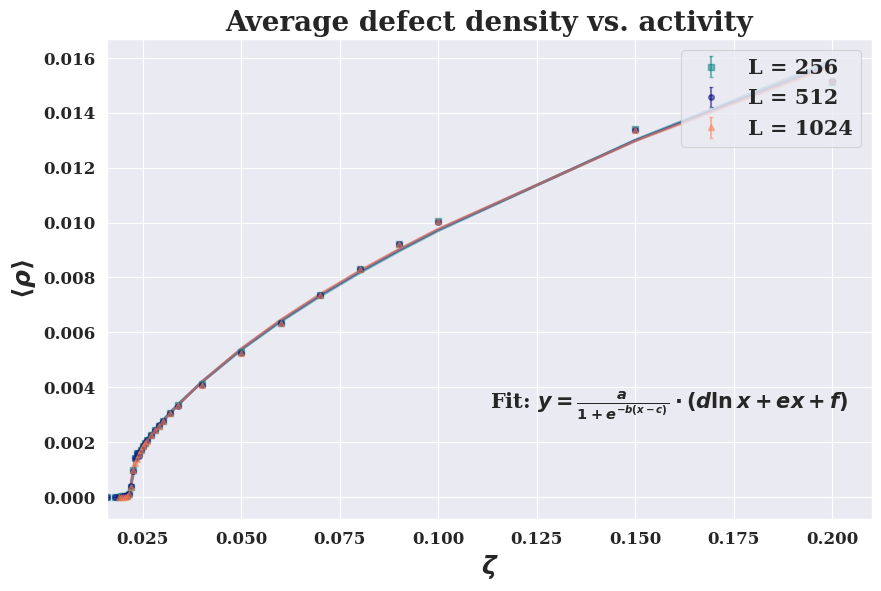

In [79]:
fig, ax = plt.subplots(figsize=(9, 6))
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
for i in range(len(input_paths)):
    act_cutoff_lower_idx = act_list[i].index(act_cutoff_lower)

    ax.errorbar(act_list[i], av_defects[i][:, 0], yerr = av_defects[i][:, 1], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)
    ax.plot(act_list[i][act_cutoff_lower_idx:], fit_func(np.array(act_list[i][act_cutoff_lower_idx:]), *av_defects_fit[i].values), color = f'C{i}', linewidth=2, alpha=0.5)
ax.legend(loc='upper right')
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0.016, .21)
#ax.set_ylim(0, 0.004)
ax.text(0.5, 0.27, r'Fit: $y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$', fontsize=15, transform=ax.transAxes,verticalalignment='top')

fig.tight_layout()
plt.show()


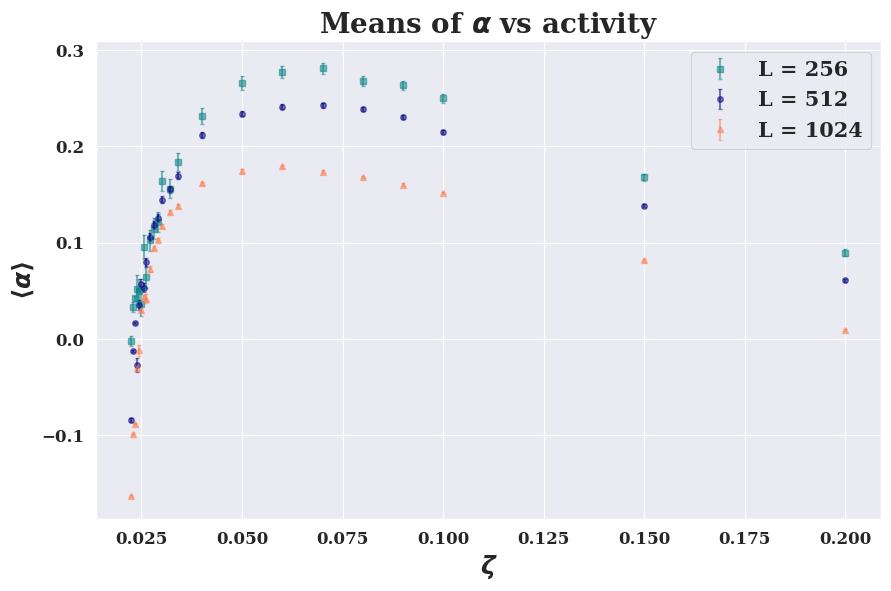

In [35]:
# plot weighted mean and error on mean for all frames and activities
fig2, ax2 = plt.subplots(figsize=(9,6))

for i, act in enumerate(act_list):
        ax2.errorbar(act, hu_fit_params[i][:,0], hu_fit_params[i][:,2], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)

ax2.set_xlabel(r'$\zeta$')
ax2.set_ylabel(r'$\langle \alpha \rangle$')

ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [ ]:
cutoff = 0
for j, windows in enumerate(window_sizes):
    norm = 1 # xi_av[j, act_max_idx]
    
    print("\nWindow size: ", windows)
    print(xi_av[j, cutoff:]/ norm)
    print(xi_av_old[j, cutoff:]/ norm)
    print(act_list[cutoff + np.argmax(xi_av[j,cutoff:] / norm)])
    print(act_list[cutoff + np.argmax(xi_av_old[j,cutoff:] / norm)])

In [226]:
act_list[act_max_idx]

0.021

In [116]:
LX

array([ 256,  512, 1024])

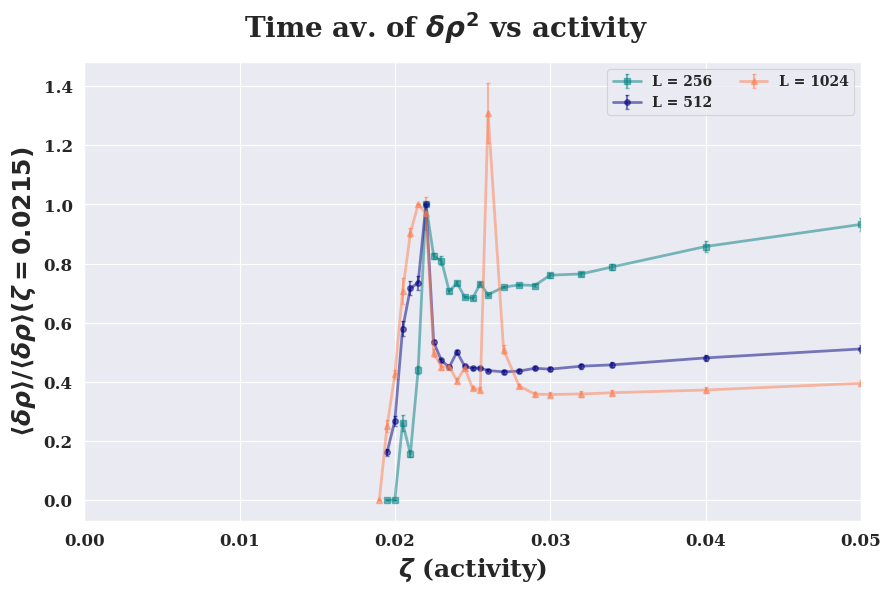

In [163]:
fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 0
max_window_cutoff_idx = -1
act_max = 0.022

for i, (xi_val,xi_err) in enumerate(zip(xi_av, xi_std)):
  if i == 0:
    min_window_cutoff_idx = 7
    max_window_cutoff_idx = -7
  else:
    min_window_cutoff_idx = 2
    max_window_cutoff_idx = -2
  if i == 2:
    act_max = 0.0215
  if i<3:
    xi = xi_val[min_window_cutoff_idx:max_window_cutoff_idx, min_act_cutoff_idx:].astype(np.float64)
    xi_error = xi_err[min_window_cutoff_idx:max_window_cutoff_idx, min_act_cutoff_idx:].astype(np.float64)

    act_max_idx = act_list[i].index(act_max)
    Nwindows = xi.shape[0]
    xi *= ( av_defects[i][:,0] * LX[i] ** 2) 
    xi_error *= ( av_defects[i][:,0] * LX[i] ** 2) 

    norm = xi[:, act_max_idx]

    xi = xi / norm[:, None]
    xi_error = xi_error / norm[:, None]

    xi_mean = np.mean(xi, axis=0)
    xi_rms = np.std(xi, axis=0) / np.sqrt(Nwindows)

    norm = xi_mean[act_max_idx]

    ax.errorbar(act_list[i], xi_mean, xi_rms , fmt = f'{marker_shape[i]}-', label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)

ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_max}) $')
ax.set_xlim(0.0,0.05)
#ax.set_xscale('log')


#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

In [43]:
LX

array([ 256,  512, 1024])

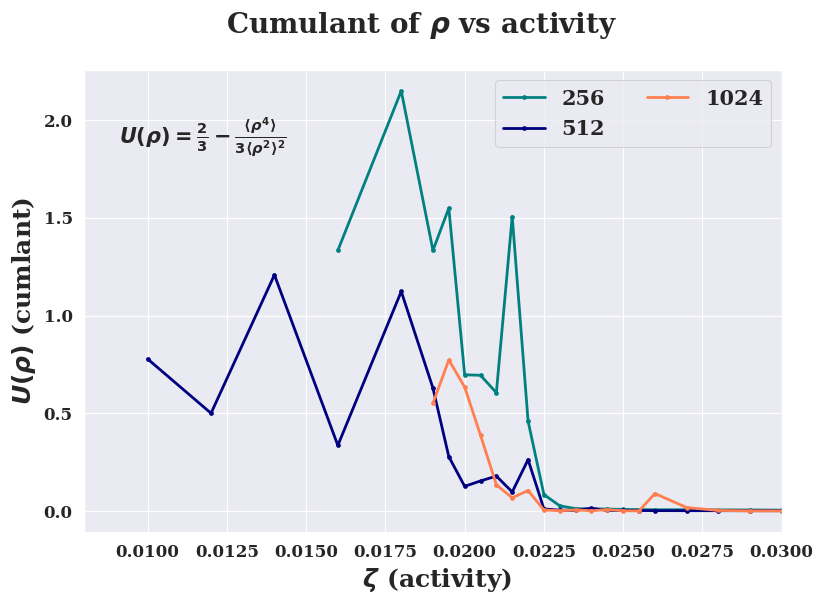

In [63]:

fig, ax = plt.subplots(figsize=(9, 6))
for i, binder in enumerate(binder_tot):
    ax.plot(act_list[i], 2/3 - binder[:len(act_list[i])], '.-', label=rf'{LX[i]}')

ax.set_xlim(0.008, 0.03)

ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
#ax.axvline(x=0.0209, color='black', linestyle='--', alpha=0.5, label = 'Crossover')
#ax.axvline(x=0.019, color='black', linestyle='--', alpha=0.5,)
ax.text(0.05, 0.9, r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$', fontsize=15, transform=ax.transAxes,verticalalignment='top')

ax.legend(loc='upper right', ncol=2,)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()